## Classificando os eventos de partículas sólidas usando o modelo XGBoost

#### MJT@Jarinu, 03-Nov-2021


In [18]:
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



In [19]:
# data from Gdrive
!gdown --id 1PzHJryPP_JQ27CL0uVFze5tFGnXx4Tov


/bin/bash: gdown: command not found


In [20]:

# load the training dataset
air_data = pd.read_csv('/mnt/g/Meu Drive/Postdoc/ProjetoLu/epu_dados_absolutos.csv')
air_data.head()

# just dropped one of the features: wind categorical
# TODO: test with it

features = ['temp','rad','vv','vdir','prec','rh','press']
label = 'emp'
X, y = air_data[features].values, air_data[label].values

adr = air_data[air_data['emp']==1]
adr[features]

,temp,rad,vv,vdir,prec,rh,press
101,31.9,18.978,1.12270,157.5,0.0,68.667,926.98
102,27.5,16.689,1.70140,157.5,0.0,81.750,928.40
103,30.5,18.792,1.29630,67.5,0.0,76.167,926.69
104,30.8,19.379,1.42360,292.5,0.0,69.333,925.70
105,28.5,13.545,1.31940,157.5,0.0,82.458,926.27
...,...,...,...,...,...,...,...
4637,31.2,23.291,1.63190,67.5,0.0,63.833,929.70
4638,31.7,22.699,0.97222,-1.0,0.0,65.750,929.31
4639,33.2,24.328,1.93290,315.0,0.0,47.250,928.20
4640,33.2,22.738,1.41200,0.0,0.0,57.583,929.96


In [21]:
# lets get some basic information about the data
air_data[features].describe()

,temp,rad,vv,vdir,prec,rh,press
count,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000,4748.000000
mean,25.806634,15.735807,1.555196,135.341618,4.455959,80.103604,926.131662
std,4.579707,6.194714,0.501910,96.077561,11.130546,8.626717,3.488280
min,8.600000,0.400000,0.046296,-1.000000,0.000000,34.333000,914.880000
25%,22.600000,11.531500,1.215300,67.500000,0.000000,75.417000,923.680000
50%,26.200000,15.578000,1.495000,112.500000,0.000000,80.958000,925.920000
75%,29.200000,19.948000,1.840300,157.500000,2.400000,86.042000,928.490000
max,37.200000,34.183000,4.594900,337.500000,139.300000,97.000000,938.000000


# Dados de poluição do ar - não balanceados

In [22]:
# Importing needed
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



/home/mteix/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:29:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Matriz de confusão

Nota-se que quase não existem predições com o evento. A matrix de confisão também nos mostra que estes são praticamente não identificáveis em meio às falsas previsões. 


@Lu: existem dados disponíveis para que possamos testar uma regressão? 


Acurácia: 89.9649 % 


Matriz de confusão:
 [[1217   49]
 [  94   65]]


/tmp/ipykernel_294/1196942807.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/tmp/ipykernel_294/1196942807.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


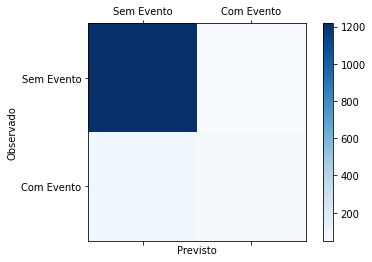

In [23]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

accuracy = accuracy_score(y_test, y_pred)

print("=================================================\n")
print("Acurácia: {:.4f} %".format((accuracy * 100.0)), "\n")
print("=================================================\n")

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Matriz de confusão:\n', conf_mat)
labels = ['Sem Evento', 'Com Evento']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Previsto')
plt.ylabel('Observado')
plt.show()


 ### Vamos tentar tratar o desbalanceio destes dados

In [24]:
# # Contando os valores da coluna emp
# #air_data.columns

# cnt_emp_0, cnt_emp_1 = air_data.emp.value_counts()

# emp_0 = air_data[air_data['emp']==0]
# emp_1 = air_data[air_data['emp']==1]


### _Oversampling_ (exemplo)
Visto não temos muitas amostras vamos fazer um _oversampling_ de emp_1

In [25]:
# emp_1_over = emp_1.sample(cnt_emp_0,replace = True)
# test_over =  pd.concat([emp_0,emp_1_over],axis = 0)  #lembrando que axis = 0 é a vertical

# print(test_over.emp.value_counts())
# test_over.emp.value_counts().plot(kind = 'bar', title = 'Contagem com oversampling em emp=1')

## Usando o módulo de _imbalanced learning_ do Python

Aqui serão gerados os dados _over_ e _undersampled_

In [26]:
from imblearn import over_sampling
from imblearn import under_sampling
from imblearn import combine


### _Random oversampling_ (ros) 

In [27]:
### Oversampling the data and just printing results 

from imblearn.over_sampling import RandomOverSampler, SMOTE

ros = RandomOverSampler()

X_ros, y_ros = ros.fit_resample(X, y)


print('Foram introduzidos ', X_ros.shape[0] - X.shape[0], 'novos pontos aleatórios')

# plot_2d_space(X_ros, y_ros, 'Random over-sampling')


Foram introduzidos  3730 novos pontos aleatórios


### SMOTE (sm)

In [28]:

from imblearn.over_sampling import RandomOverSampler, SMOTE

smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X, y)


### SMOTENC (smc)

In [29]:
from imblearn.over_sampling import SMOTENC

smotenc = SMOTENC(sampling_strategy='minority',categorical_features=[5, 6])
X_smc, y_smc = smotenc.fit_resample(X, y)

In [30]:
# plot_2d_space(X_smc, y_smc, 'SMOTENC over-sampling')

### _undersampling_ (RUS)


In [31]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus  = rus.fit_resample(X,y)


## Treinando os modelos e analisando os resultados

### RUS

/home/mteix/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:29:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Acurácia: 83.9869 % 


Matriz de confusão:
 [[129  21]
 [ 28 128]]


/tmp/ipykernel_294/856163947.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/tmp/ipykernel_294/856163947.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


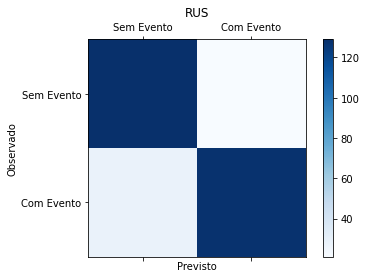

In [32]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.3)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("=================================================\n")
print("Acurácia: {:.4f} %".format((accuracy * 100.0)), "\n")
print("=================================================\n")
### MATRIZ DE CONFUSAO 

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Matriz de confusão:\n', conf_mat)

labels = ['Sem Evento', 'Com Evento']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Previsto')
plt.ylabel('Observado')
plt.title('RUS')
plt.show()


### ROS

/home/mteix/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:29:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Acurácia: 96.1871 % 


Matriz de confusão:
 [[1177   94]
 [   3 1270]]


/tmp/ipykernel_294/1161883808.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/tmp/ipykernel_294/1161883808.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


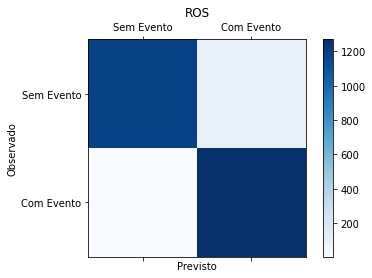

In [33]:

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.3)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("=================================================\n")
print("Acurácia: {:.4f} %".format((accuracy * 100.0)), "\n")
print("=================================================\n")
### MATRIZ DE CONFUSAO 

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Matriz de confusão:\n', conf_mat)

labels = ['Sem Evento', 'Com Evento']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Previsto')
plt.ylabel('Observado')
plt.title('ROS')
plt.show()


/home/mteix/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:29:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Acurácia: 92.6887 % 


Matriz de confusão:
 [[1186  121]
 [  65 1172]]


/tmp/ipykernel_294/1198858123.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/tmp/ipykernel_294/1198858123.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


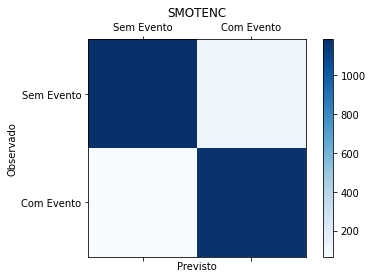

In [34]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X_smc, y_smc, test_size=0.3)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("=================================================\n")
print("Acurácia: {:.4f} %".format((accuracy * 100.0)), "\n")
print("=================================================\n")
### MATRIZ DE CONFUSAO 

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Matriz de confusão:\n', conf_mat)

labels = ['Sem Evento', 'Com Evento']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Previsto')
plt.ylabel('Observado')
plt.title('SMOTENC')
plt.show()


/home/mteix/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:29:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Acurácia: 93.0425 % 


Matriz de confusão:
 [[1139  113]
 [  64 1228]]


/tmp/ipykernel_294/2220114472.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/tmp/ipykernel_294/2220114472.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


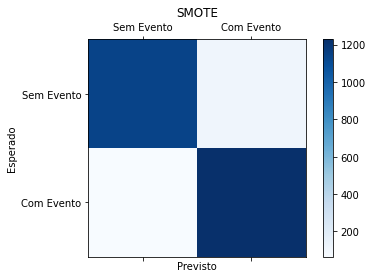

In [35]:
#### Para o SMOTE  #####

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("=================================================\n")
print("Acurácia: {:.4f} %".format((accuracy * 100.0)), "\n")
print("=================================================\n")
### MATRIZ DE CONFUSAO 

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Matriz de confusão:\n', conf_mat)

labels = ['Sem Evento', 'Com Evento']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Previsto')
plt.ylabel('Esperado')
plt.title('SMOTE')
plt.show()


In [36]:
# #### Uncomment to save the model

params = model.get_params()
model.save_model('my_modelSMOTE90.xgb')

In [37]:
## tentando umas previsões

## Table to input values in model
temp = 34
rad = 23
vv = 1.6
vdir = 67 
prec = 0.0
rh = 63
press = 929
##

input_pred = [temp,rad,vv,vdir,prec,rh,press]
isEvent = model.predict(input_pred)

print('------ EMP tipo %d ocorreu ------' % isEvent)

ValueError: ('Expecting 2 dimensional numpy.ndarray, got: ', (7,))

## Imprimindo a árvore do melhor modelo ajustado

[('f0', 'temp'), ('f1', 'rad'), ('f2', 'vv'), ('f3', 'vdir'), ('f4', 'prec'), ('f5', 'rh'), ('f6', 'press')]


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

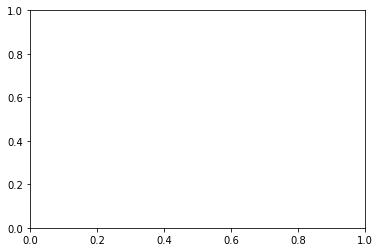

In [39]:
from xgboost import plot_tree, to_graphviz, plot_importance
import matplotlib.pyplot as plt
# plot_importance(model)

# Just to remember let's print the features
features_id = ['f0','f1','f2','f3','f4','f5','f6']
tab_features = zip(features_id,features)
print(list(tab_features))
plot_tree(model,num_trees=0,rankdir='LR')


plt.gcf().set_size_inches(15,15)

plt.show()

In [ ]:
!cp drive/My Drive/Colab Notebooks/LuData- ./

In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')